In [98]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [99]:
input_var = tf.Variable(initial_value = 3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [100]:
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print("Gradient is not tracked by tape by default as it is not a trainable variable. Gradient: ", gradient)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print("Need to use tape.watch(). Gradient: ", gradient)

Gradient is not tracked by tape by default as it is not a trainable variable. Gradient:  None
Need to use tape.watch(). Gradient:  tf.Tensor(6.0, shape=(), dtype=float32)


In [101]:
# Second order gradient tracking

time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    speed = inner_tape.gradient(position, time)

acceleration = outer_tape.gradient(speed, time)

print(speed) 
print(acceleration)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


## Linear Classifier from scratch

In [102]:
# Generate data

num_samples_per_class = 1000

negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, .5], [.5, 1]],
    size=num_samples_per_class)

positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, .5], [.5, 1]],
    size=num_samples_per_class)

In [103]:
positive_samples.shape

(1000, 2)

In [104]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
inputs.shape

(2000, 2)

In [105]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype=np.float32),
                     np.ones((num_samples_per_class, 1), dtype=np.float32)))
targets.shape

(2000, 1)

In [106]:
inputs[:5]

array([[-1.0114179 ,  2.7048538 ],
       [-2.2272222 ,  1.459902  ],
       [ 0.05024752,  2.6249197 ],
       [ 0.02805144,  2.4491014 ],
       [-0.82356423,  3.0030627 ]], dtype=float32)

In [107]:
inputs[:5, 0]

array([-1.0114179 , -2.2272222 ,  0.05024752,  0.02805144, -0.82356423],
      dtype=float32)

In [108]:
targets[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

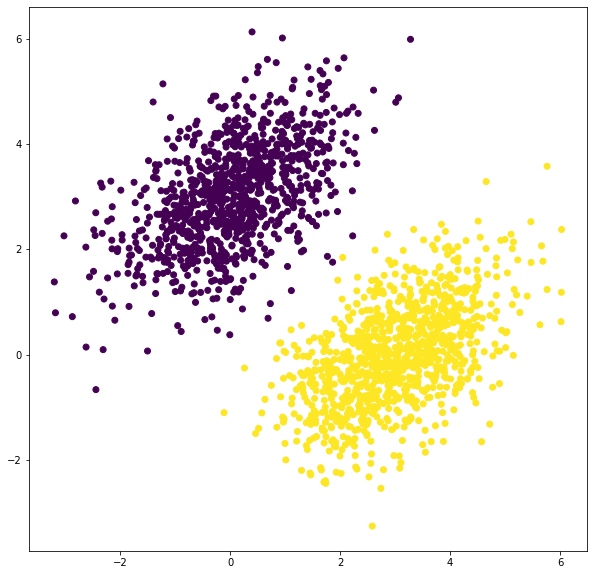

In [109]:
fig = plt.figure(figsize=(10,10))
plt.scatter(inputs[:,0], inputs[:,1], c=targets[:, 0])

In [110]:
input_dim = 2
output_dim = 1

W = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(tf.zeros((output_dim,)))

In [111]:
def model(inputs):
    return tf.matmul(inputs, W) + b 

In [112]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    
    return tf.reduce_mean(per_sample_losses)

In [113]:
def training_step(inputs, targets, learning_rate=0.1):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)

    return loss

In [114]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f'Loss at step {step}: {loss:.4f}')

Loss at step 0: 0.1825
Loss at step 1: 0.0789
Loss at step 2: 0.0726
Loss at step 3: 0.0682
Loss at step 4: 0.0644
Loss at step 5: 0.0610
Loss at step 6: 0.0578
Loss at step 7: 0.0549
Loss at step 8: 0.0523
Loss at step 9: 0.0498
Loss at step 10: 0.0476
Loss at step 11: 0.0456
Loss at step 12: 0.0437
Loss at step 13: 0.0420
Loss at step 14: 0.0405
Loss at step 15: 0.0390
Loss at step 16: 0.0377
Loss at step 17: 0.0365
Loss at step 18: 0.0354
Loss at step 19: 0.0344
Loss at step 20: 0.0335
Loss at step 21: 0.0327
Loss at step 22: 0.0319
Loss at step 23: 0.0312
Loss at step 24: 0.0306
Loss at step 25: 0.0300
Loss at step 26: 0.0294
Loss at step 27: 0.0289
Loss at step 28: 0.0285
Loss at step 29: 0.0281
Loss at step 30: 0.0277
Loss at step 31: 0.0273
Loss at step 32: 0.0270
Loss at step 33: 0.0267
Loss at step 34: 0.0265
Loss at step 35: 0.0262
Loss at step 36: 0.0260
Loss at step 37: 0.0258
Loss at step 38: 0.0256
Loss at step 39: 0.0254


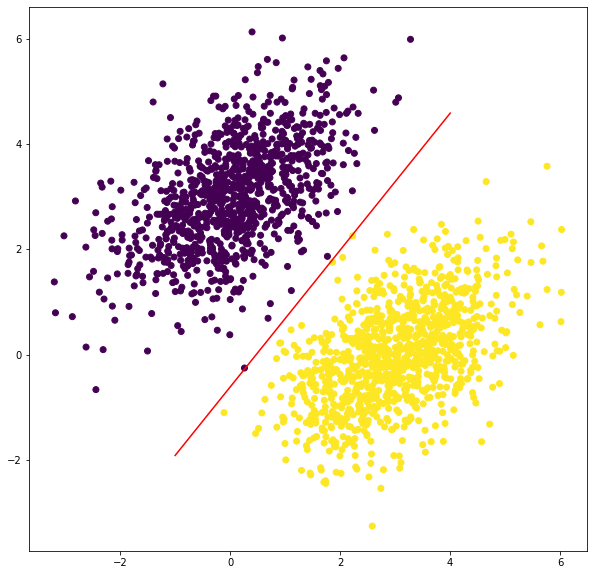

In [115]:
predictions = model(inputs)

# Generate X Coordinates
x = np.linspace(-1, 4, 100)

# Generate respective Y coordinates using weights and biases
y = -W[0] / W[1] * x + (0.5 - b) / W[1]

# Plot
fig = plt.figure(figsize=(10,10))
plt.plot(x, y, '-r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Keras

In [116]:
from tensorflow import keras

In [117]:
class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
    
    def build(self, input_shape):
        ''' 
        In Keras, weights are initialized in build(), not __init__(). This facilitates dynamic inference of input shape via __call__()
        in parent Layer class.
        '''
        input_dim = input_shape[-1]
        # self.W = tf.Variable(tf.random.uniform(shape=(input_dim, self.units)))
        self.W = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,), initializer='zeros')
    
    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b 
        if self.activation is not None:
            y = self.activation(y)
        
        return y

In [118]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [119]:
# In Keras, input dimensions are auto inferred

model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32)])

# Compare this to Tensorflow, where input dimensions need specifying
'''

model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

'''

'\n\nmodel = NaiveSequential([\n    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),\n    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)\n])\n\n'

In [120]:
# Compile takes in optimizer, loss, and metrics

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

Eg. 

Optimizers: SGD (with/out momentum), RMSprop, Adam, Adagrad

Losses: CategoricalCrossentropy (Multi Class Classification), SparseCategoricalCrossentropy, BinaryCrossentropy(Two Class Classification), MeanSquaredError, KLDivergence, CosineSimilarity

Metrics: CategoricalAccuracy, SparseCategoricalAccuracy, BinaryAccuracy, AUC, Precision, Recall

In [121]:
# Fit takes in training samples, labels, epochs, and batch size

history = model.fit(inputs, targets, epochs=5, batch_size=128)

Epoch 1/5


 8/16 [==============>...............] - ETA: 0s - loss: 0.8015 - binary_accuracy: 0.4647

2023-07-12 10:13:12.947412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 8ms/step - loss: 0.7934 - binary_accuracy: 0.4614
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.7616 - binary_accuracy: 0.4678
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.7350 - binary_accuracy: 0.4744
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.7097 - binary_accuracy: 0.4803
Epoch 5/5
16/16 [==============================] - 0s 6ms/step - loss: 0.6851 - binary_accuracy: 0.4870


In [122]:
history.history

{'loss': [0.793376624584198,
  0.7616428732872009,
  0.7350303530693054,
  0.709651529788971,
  0.6851233243942261],
 'binary_accuracy': [0.46140626072883606,
  0.4678281545639038,
  0.47440627217292786,
  0.48029690980911255,
  0.48698440194129944]}

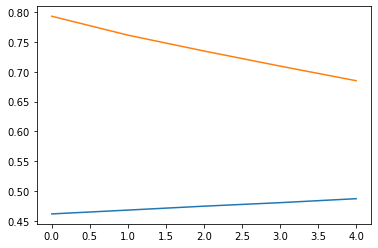

In [123]:
plt.plot(history.epoch, history.history['binary_accuracy'])
plt.plot(history.epoch, history.history['loss'])

In [128]:
# Validation

model = keras.Sequential([keras.layers.Dense(1)])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5


2023-07-12 10:15:22.794646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 8ms/step - loss: 0.6657 - binary_accuracy: 0.9386 - val_loss: 0.0281 - val_binary_accuracy: 1.0000
Epoch 2/5
 1/88 [..............................] - ETA: 0s - loss: 0.0213 - binary_accuracy: 1.0000

2023-07-12 10:15:23.592480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 7ms/step - loss: 0.0706 - binary_accuracy: 0.9607 - val_loss: 0.0368 - val_binary_accuracy: 1.0000
Epoch 3/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0758 - binary_accuracy: 0.9536 - val_loss: 0.1627 - val_binary_accuracy: 0.7817
Epoch 4/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0736 - binary_accuracy: 0.9571 - val_loss: 0.0474 - val_binary_accuracy: 0.9867
Epoch 5/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0710 - binary_accuracy: 0.9593 - val_loss: 0.1249 - val_binary_accuracy: 0.9533


In [129]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 6ms/step - loss: 0.1249 - binary_accuracy: 0.9533


In [130]:
predictions = model.predict(val_inputs, batch_size=128)
predictions[:10]

2023-07-12 10:15:29.746610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[1.1811141 ],
       [0.01801401],
       [0.44063383],
       [0.03061926],
       [0.04664499],
       [1.0309306 ],
       [0.3157036 ],
       [0.4251612 ],
       [1.2296538 ],
       [1.566746  ]], dtype=float32)